In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from state_space_setup import *

In [2]:
trans_prob_matrix = np.load("trans_prob_matrix.npy")
policy = pd.read_csv('policy.csv')

# format and extract the maximum number of parts from the loaded policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

Maximum number of parts in the inventory: 41


In [3]:
def downtime_cost(num_parts, k=10080, lambda_=2, cost_per_week=16800):
    if num_parts == 0:
        return cost_per_week

    m = np.arange(1, k + 1)
    i = np.arange(num_parts)
    lambda_m = (lambda_ / k) * (k - m[:, None])  

    pmf = stats.poisson.pmf(i[None, :], lambda_m)
    sf = stats.poisson.sf(num_parts - i - 1, lambda_ / k)

    prob = np.sum(pmf * sf, axis=1)
    weighted_cost = prob * (m / k) * cost_per_week
    total_cost = np.sum(weighted_cost)
    normalisation = stats.poisson.sf(num_parts - 1, lambda_)

    return total_cost / normalisation


def cost_function(old_state, new_state, action, down_vect):

    holding_cost_as_percentage = 0.008
    price_per_part = 100
    ordering_cost=200


    if action == 0:
        order_cost = 0
    else:
        order_cost = ordering_cost + price_per_part * action

    if (new_state[0] == (old_state[1] + action) and new_state[1] == 0) or (new_state[0] == 0):
        shortage_cost = down_vect[old_state[0]]
    else:
        shortage_cost = 0

    holding_cost = holding_cost_as_percentage * price_per_part * (max(new_state[0] - 1, 0))

    return holding_cost + order_cost + shortage_cost


def expected_action_value(current_state, action, values):
    global maximum_parts
    global cost_matrix
    global trans_prob_matrix

    discount_factor = 0.995

    current_state_idx = get_index(current_state[0], current_state[1], maximum_parts)

    probs = trans_prob_matrix[current_state_idx, :, action]
    costs = cost_matrix[current_state_idx, :, action]
    expected_value = np.dot(probs, costs + discount_factor * values)
    return expected_value

In [4]:
number_of_periods = np.array([1, 7, 168, 10080])  # week, day, hour, minute
names = ["week", "day", "hour", "minute"]
policies = np.zeros((len(number_of_periods), 2))

# Value iteration setup
error = 1e-6
values = np.zeros(len(state_space))
delta = 2 * error

In [5]:
for k, period in enumerate(number_of_periods):
    print(f"Starting iteration {k + 1}/{len(number_of_periods)} for splitting shortage by {names[k]}...")
    print("Generating cost matrix...")

    downtime_vector = np.array([downtime_cost(num_parts, k=period) for num_parts in np.arange(maximum_parts + 1)])
    cost_matrix = np.zeros((len(state_space), len(state_space), maximum_parts + 1))
    for i, s_old in enumerate(state_space):
        for j, s_new in enumerate(state_space):
            for a in range(maximum_parts + 1):
                cost_matrix[i, j, a] = cost_function(s_old, s_new, a, down_vect=downtime_vector)
    
    print("Cost matrix generated.")

    print("Starting value iteration...")
    while delta >= error:
        delta = 0
        old_values = np.copy(values)
        for i, state in enumerate(state_space):
            v = values[i]
            action_space = get_action_space(state, maximum_parts)
            action_costs = np.array([
                expected_action_value(state, act, old_values)
                for act in action_space
            ])
            values[i] = np.min(action_costs)
            delta = max(delta, abs(v - values[i]))

    print("Value iteration completed.")

    print("Generating policy records...")

    policy_records = []
    for state in state_tuples:
        action_space = get_action_space(state, maximum_parts)
        action_costs = np.array([
            expected_action_value(state, act, values)
            for act in action_space
        ])
        order = action_space[np.argmin(action_costs)]
        policy_records.append((state, order))
    
    policy_df = pd.DataFrame(policy_records, columns=["State", "Order_size"])
    policy_df["IP"] = policy_df["State"].apply(sum)
    policy_df["New_IP"] = policy_df["IP"] + policy_df["Order_size"]
    filtered_policy_df = policy_df[policy_df["Order_size"] != 0]
    s = filtered_policy_df["IP"].max()
    S = filtered_policy_df["New_IP"].max()
    policies[k] = [s, S]
    policy_df.to_csv(f"shortage_policies/shortage_by_{names[k]}.csv", index=False)
    
    print(f"Policy for splitting shortage by {names[k]} saved to 'shortage_by_{names[k]}.csv'.")

    print(f"Iteration {k + 1}/{len(number_of_periods)} completed. Approximate (s,S) policy obtained is: \ns = {s}, S = {S}")
    values = np.zeros(len(state_space))
    delta = 2 * error

Starting iteration 1/4 for splitting shortage by week...
Generating cost matrix...
Cost matrix generated.
Starting value iteration...
Value iteration completed.
Generating policy records...
Policy for splitting shortage by week saved to 'shortage_by_week.csv'.
Iteration 1/4 completed. Approximate (s,S) policy obtained is: 
s = 12, S = 37
Starting iteration 2/4 for splitting shortage by day...
Generating cost matrix...
Cost matrix generated.
Starting value iteration...
Value iteration completed.
Generating policy records...
Policy for splitting shortage by day saved to 'shortage_by_day.csv'.
Iteration 2/4 completed. Approximate (s,S) policy obtained is: 
s = 11, S = 36
Starting iteration 3/4 for splitting shortage by hour...
Generating cost matrix...
Cost matrix generated.
Starting value iteration...
Value iteration completed.
Generating policy records...
Policy for splitting shortage by hour saved to 'shortage_by_hour.csv'.
Iteration 3/4 completed. Approximate (s,S) policy obtained is:

In [6]:
# Use cost matrix split by seconds for testing the above generated policies
downtime_vector = np.array([downtime_cost(num_parts, k=604800) for num_parts in np.arange(maximum_parts + 1)])
cost_matrix = np.zeros((len(state_space), len(state_space), maximum_parts + 1))
for i, s_old in enumerate(state_space):
    for j, s_new in enumerate(state_space):
        for a in range(maximum_parts + 1):
            cost_matrix[i, j, a] = cost_function(s_old, s_new, a, down_vect=downtime_vector)

In [7]:
discount_factor = 0.995
value_iteration_values = np.load("values.npy")


def generate_demand(num_periods=1000, lambda_=2, p=0.9):
    demand = np.random.poisson(lam=lambda_, size=num_periods)
    arrivals = np.random.binomial(1, p, size=num_periods)

    return np.column_stack((demand, arrivals))


def apply_policy(initial_state, policy_df, demands):
    global maximum_parts, cost_matrix

    num_periods = len(demands)
    policy_dict = dict(zip(policy_df["State"], policy_df["Order_size"]))

    states = np.zeros((num_periods + 1, 2), dtype=int)
    actions = np.zeros(num_periods + 1, dtype=int)
    costs = np.zeros(num_periods + 1, dtype=float)

    states[0] = initial_state
    actions[0] = policy_dict[tuple(states[0])]
    costs[0] = 0

    for i in range(num_periods):
        current_state = states[i]
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        action = actions[i]

        new_IL = max(0, current_state[0] - demands[i, 0]) + (current_state[1] + action) * demands[i, 1]
        new_OP = (current_state[1] + action) * (1 - demands[i, 1])
        
        new_idx = get_index(new_IL, new_OP, maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs[i+1] = cost

        states[i+1] = (new_IL, new_OP)
        actions[i+1] = policy_dict[(new_IL, new_OP)]

    SAC_df = pd.DataFrame({
        "States" : [tuple(s) for s in states],
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df


def total_cost(simulated_data):
    global discount_factor
    
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    discounted_cost = np.sum(factor_sequence * np.array(simulated_data["Costs"]))
        
    return discounted_cost

In [8]:
size = 10000


sampled_costs_flat = np.zeros(size)
sampled_costs_by_minute = np.zeros(size)

policy_flat = pd.read_csv("shortage_policies/shortage_by_week.csv")
policy_flat['State'] = policy_flat['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))
policy_by_minute = pd.read_csv("shortage_policies/shortage_by_minute.csv")
policy_by_minute['State'] = policy_by_minute['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))


for i in range(size):
    demand = generate_demand(4000, 2, 0.9)
    state_idx = np.random.choice(np.arange(len(state_tuples)))
    state = state_tuples[state_idx]
    sampled_costs_flat[i] = total_cost(apply_policy(state, policy_flat, demand))
    sampled_costs_by_minute[i] = total_cost(apply_policy(state, policy_by_minute, demand))
    if (i + 1) % 100 == 0:
        print(f"Finished sample {i + 1}/10000.")


Finished sample 100/10000.
Finished sample 200/10000.
Finished sample 300/10000.
Finished sample 400/10000.
Finished sample 500/10000.
Finished sample 600/10000.
Finished sample 700/10000.
Finished sample 800/10000.
Finished sample 900/10000.
Finished sample 1000/10000.
Finished sample 1100/10000.
Finished sample 1200/10000.
Finished sample 1300/10000.
Finished sample 1400/10000.
Finished sample 1500/10000.
Finished sample 1600/10000.
Finished sample 1700/10000.
Finished sample 1800/10000.
Finished sample 1900/10000.
Finished sample 2000/10000.
Finished sample 2100/10000.
Finished sample 2200/10000.
Finished sample 2300/10000.
Finished sample 2400/10000.
Finished sample 2500/10000.
Finished sample 2600/10000.
Finished sample 2700/10000.
Finished sample 2800/10000.
Finished sample 2900/10000.
Finished sample 3000/10000.
Finished sample 3100/10000.
Finished sample 3200/10000.
Finished sample 3300/10000.
Finished sample 3400/10000.
Finished sample 3500/10000.
Finished sample 3600/10000.
F

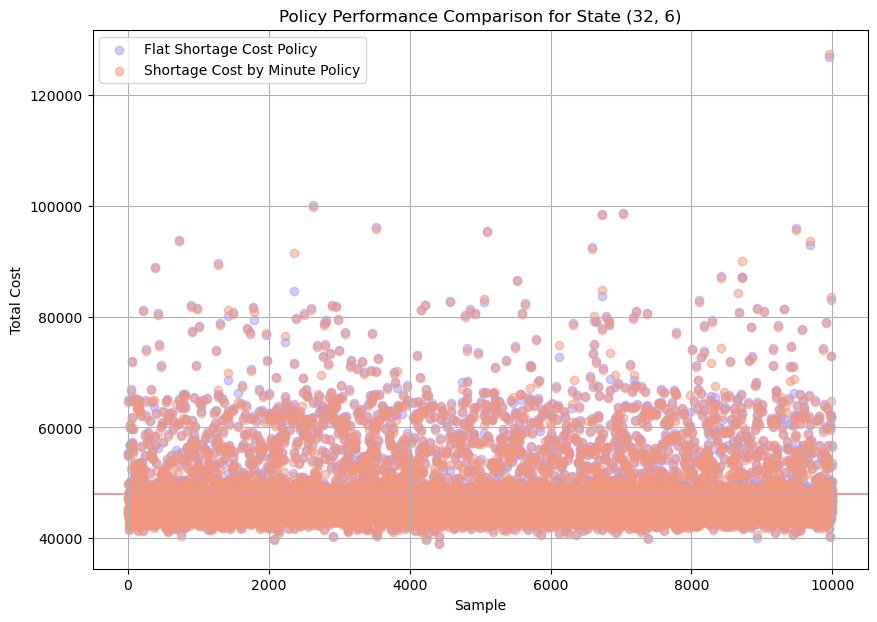

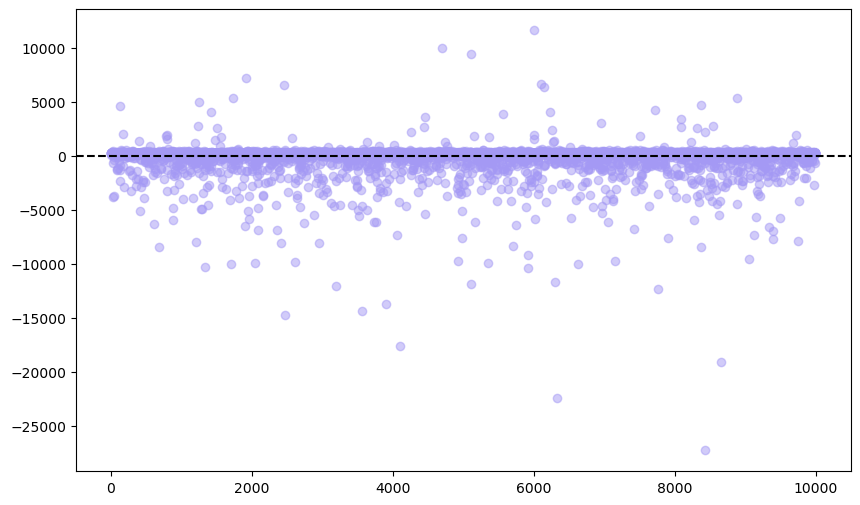

Mean difference of cost between constant and by-minute policies: 0.14139226891855167 %
Median difference of cost between constant and by-minute policies: 0.5122296728970389 %
Proportion of samples where the by-minute policy outperforms flat shortage cost policy: 0.8875


In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(np.arange(size), sampled_costs_flat, color='#A499F4', alpha=0.5, label='Flat Shortage Cost Policy')
plt.scatter(np.arange(size), sampled_costs_by_minute, color='#F1977F', alpha=0.5, label='Shortage Cost by Minute Policy')

plt.axhline(np.mean(sampled_costs_flat), color='#A499F4', linestyle='-', alpha=0.7)
plt.axhline(np.mean(sampled_costs_by_minute), color='#F1977F', linestyle='-', alpha=0.7)

plt.xlabel("Sample")
plt.ylabel("Total Cost")
plt.title(f"Policy Performance Comparison for State {state}")
plt.legend()
plt.grid(True)
plt.savefig("plots/SA_shortage_cost.pdf", format="pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(size), sampled_costs_flat - sampled_costs_by_minute, color='#A499F4', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', label='No Difference')
plt.show()

print("Mean difference of cost between constant and by-minute policies:", np.mean(sampled_costs_flat - sampled_costs_by_minute)/np.mean(sampled_costs_flat) * 100, "%")
print("Median difference of cost between constant and by-minute policies:", np.median(sampled_costs_flat - sampled_costs_by_minute)/np.mean(sampled_costs_flat) * 100, "%")
print("Proportion of samples where the by-minute policy outperforms flat shortage cost policy:", np.mean((sampled_costs_flat - sampled_costs_by_minute) > 0))